In [125]:
import pandas as pd

train=pd.read_csv("data/DailyDelhiClimateTrain.csv")
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [126]:
test=pd.read_csv("data/DailyDelhiClimateTest.csv")
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


<Axes: xlabel='date', ylabel='meantemp'>

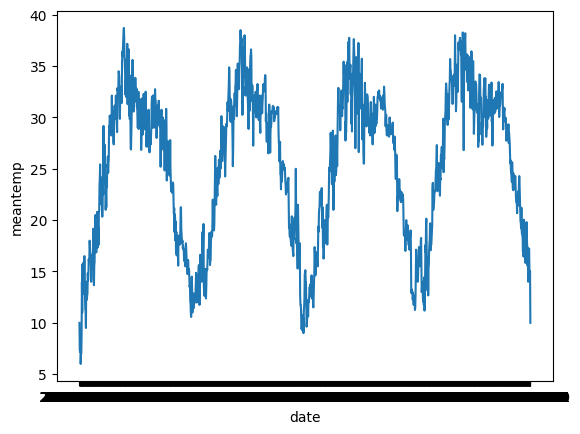

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="date", y="meantemp", data=train)

<Axes: xlabel='date', ylabel='humidity'>

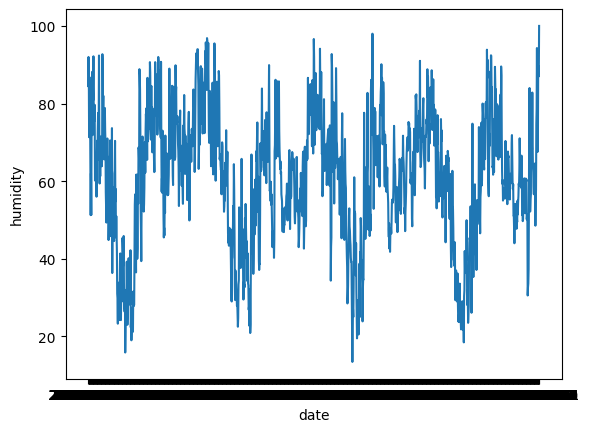

In [128]:
sns.lineplot(x="date", y="humidity", data=train)

In [129]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [130]:
train = train.sort_values("date")
train.set_index("date", inplace=True)

In [131]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [132]:
X=train.drop("meantemp", axis=1).values
y=train["meantemp"].values

In [133]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_x.fit_transform(X)

In [134]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # Reshaping y to 2D array for scaling

In [145]:
import numpy as np

# Reshape data for LSTM: Each single timestep becomes input, with features as the last dimension
# Shape: (num_samples, 1, num_features) - treating each row as a single timestep
X_reshaped = scaled_data.reshape(scaled_data.shape[0], 1, scaled_data.shape[1])
y_reshaped = y_scaled.reshape(-1, 1)

print("X_reshaped shape:", X_reshaped.shape)  # (num_samples, 1, num_features)
print("y_reshaped shape:", y_reshaped.shape)  # (num_samples, 1)

X_reshaped shape: (1462, 1, 3)
y_reshaped shape: (1462, 1)


In [146]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)
print("Training set shapes:", X_train.shape, y_train.shape)

Training set shapes: (1169, 1, 3) (1169, 1)


In [147]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [148]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [149]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        # We use the last hidden state for the prediction
        predictions = self.fc(lstm_out[:, -1, :])  # Last time step output
        return predictions


In [152]:
# Dynamically determine input size from the data
input_size = X_train.shape[2]  # Number of features (last dimension)
print(f"Input size (number of features): {input_size}")

model = LSTMModel(input_size=input_size, hidden_layer_size=64, output_size=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Input size (number of features): 3


In [153]:
from tqdm import tqdm

epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)  # Accumulate loss

    avg_train_loss = train_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}"):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)  # Accumulate loss

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Validating Epoch 1/200: 100%|██████████| 10/10 [00:00<00:00, 950.90it/s]


Epoch 1/200, Train Loss: 0.3763, Val Loss: 0.3173


Validating Epoch 2/200: 100%|██████████| 10/10 [00:00<00:00, 1051.23it/s]


Epoch 2/200, Train Loss: 0.3106, Val Loss: 0.2564


Validating Epoch 3/200: 100%|██████████| 10/10 [00:00<00:00, 1050.44it/s]


Epoch 3/200, Train Loss: 0.2480, Val Loss: 0.1973


Validating Epoch 4/200: 100%|██████████| 10/10 [00:00<00:00, 1332.29it/s]


Epoch 4/200, Train Loss: 0.1875, Val Loss: 0.1427


Validating Epoch 5/200: 100%|██████████| 10/10 [00:00<00:00, 1331.99it/s]


Epoch 5/200, Train Loss: 0.1338, Val Loss: 0.0990


Validating Epoch 6/200: 100%|██████████| 10/10 [00:00<00:00, 1428.43it/s]

Epoch 6/200, Train Loss: 0.0937, Val Loss: 0.0717



Validating Epoch 7/200: 100%|██████████| 10/10 [00:00<00:00, 1172.25it/s]


Epoch 7/200, Train Loss: 0.0711, Val Loss: 0.0603


Validating Epoch 8/200: 100%|██████████| 10/10 [00:00<00:00, 643.97it/s]


Epoch 8/200, Train Loss: 0.0616, Val Loss: 0.0574


Validating Epoch 9/200: 100%|██████████| 10/10 [00:00<00:00, 1332.79it/s]


Epoch 9/200, Train Loss: 0.0586, Val Loss: 0.0569


Validating Epoch 10/200: 100%|██████████| 10/10 [00:00<00:00, 1665.27it/s]


Epoch 10/200, Train Loss: 0.0574, Val Loss: 0.0564


Validating Epoch 11/200: 100%|██████████| 10/10 [00:00<00:00, 1537.16it/s]


Epoch 11/200, Train Loss: 0.0566, Val Loss: 0.0559


Validating Epoch 12/200: 100%|██████████| 10/10 [00:00<00:00, 1050.81it/s]


Epoch 12/200, Train Loss: 0.0558, Val Loss: 0.0552


Validating Epoch 13/200: 100%|██████████| 10/10 [00:00<00:00, 1332.46it/s]

Epoch 13/200, Train Loss: 0.0550, Val Loss: 0.0546

Validating Epoch 14/200: 100%|██████████| 10/10 [00:00<00:00, 1331.74it/s]


Epoch 14/200, Train Loss: 0.0542, Val Loss: 0.0539


Validating Epoch 15/200: 100%|██████████| 10/10 [00:00<00:00, 1173.43it/s]


Epoch 15/200, Train Loss: 0.0534, Val Loss: 0.0532


Validating Epoch 16/200: 100%|██████████| 10/10 [00:00<00:00, 1172.81it/s]


Epoch 16/200, Train Loss: 0.0526, Val Loss: 0.0526


Validating Epoch 17/200: 100%|██████████| 10/10 [00:00<00:00, 1173.63it/s]


Epoch 17/200, Train Loss: 0.0518, Val Loss: 0.0517


Validating Epoch 18/200: 100%|██████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch 18/200, Train Loss: 0.0510, Val Loss: 0.0510


Validating Epoch 19/200: 100%|██████████| 10/10 [00:00<00:00, 1533.62it/s]


Epoch 19/200, Train Loss: 0.0502, Val Loss: 0.0504


Validating Epoch 20/200: 100%|██████████| 10/10 [00:00<00:00, 1328.66it/s]


Epoch 20/200, Train Loss: 0.0495, Val Loss: 0.0497


Validating Epoch 21/200: 100%|██████████| 10/10 [00:00<00:00, 1174.78it/s]


Epoch 21/200, Train Loss: 0.0487, Val Loss: 0.0490


Validating Epoch 22/200: 100%|██████████| 10/10 [00:00<00:00, 1328.19it/s]


Epoch 22/200, Train Loss: 0.0479, Val Loss: 0.0485


Validating Epoch 23/200: 100%|██████████| 10/10 [00:00<00:00, 1174.91it/s]


Epoch 23/200, Train Loss: 0.0472, Val Loss: 0.0475


Validating Epoch 24/200: 100%|██████████| 10/10 [00:00<00:00, 1174.94it/s]


Epoch 24/200, Train Loss: 0.0464, Val Loss: 0.0470


Validating Epoch 25/200: 100%|██████████| 10/10 [00:00<00:00, 1174.91it/s]


Epoch 25/200, Train Loss: 0.0456, Val Loss: 0.0464


Validating Epoch 26/200: 100%|██████████| 10/10 [00:00<00:00, 1328.24it/s]


Epoch 26/200, Train Loss: 0.0448, Val Loss: 0.0456


Validating Epoch 27/200: 100%|██████████| 10/10 [00:00<00:00, 1050.15it/s]


Epoch 27/200, Train Loss: 0.0441, Val Loss: 0.0449


Validating Epoch 28/200: 100%|██████████| 10/10 [00:00<00:00, 1331.99it/s]


Epoch 28/200, Train Loss: 0.0434, Val Loss: 0.0443


Validating Epoch 29/200: 100%|██████████| 10/10 [00:00<00:00, 1332.24it/s]


Epoch 29/200, Train Loss: 0.0426, Val Loss: 0.0438


Validating Epoch 30/200: 100%|██████████| 10/10 [00:00<00:00, 1051.44it/s]


Epoch 30/200, Train Loss: 0.0420, Val Loss: 0.0432


Validating Epoch 31/200: 100%|██████████| 10/10 [00:00<00:00, 1173.95it/s]


Epoch 31/200, Train Loss: 0.0413, Val Loss: 0.0426


Validating Epoch 32/200: 100%|██████████| 10/10 [00:00<00:00, 1173.86it/s]


Epoch 32/200, Train Loss: 0.0406, Val Loss: 0.0420


Validating Epoch 33/200: 100%|██████████| 10/10 [00:00<00:00, 1050.26it/s]


Epoch 33/200, Train Loss: 0.0400, Val Loss: 0.0416


Validating Epoch 34/200: 100%|██████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch 34/200, Train Loss: 0.0394, Val Loss: 0.0409


Validating Epoch 35/200: 100%|██████████| 10/10 [00:00<00:00, 1426.25it/s]


Epoch 35/200, Train Loss: 0.0388, Val Loss: 0.0406


Validating Epoch 36/200: 100%|██████████| 10/10 [00:00<00:00, 1050.36it/s]


Epoch 36/200, Train Loss: 0.0383, Val Loss: 0.0401


Validating Epoch 37/200: 100%|██████████| 10/10 [00:00<00:00, 1173.43it/s]


Epoch 37/200, Train Loss: 0.0378, Val Loss: 0.0397


Validating Epoch 38/200: 100%|██████████| 10/10 [00:00<00:00, 1051.89it/s]


Epoch 38/200, Train Loss: 0.0373, Val Loss: 0.0394


Validating Epoch 39/200: 100%|██████████| 10/10 [00:00<00:00, 1536.04it/s]


Epoch 39/200, Train Loss: 0.0369, Val Loss: 0.0390


Validating Epoch 40/200: 100%|██████████| 10/10 [00:00<00:00, 1537.22it/s]


Epoch 40/200, Train Loss: 0.0365, Val Loss: 0.0388


Validating Epoch 41/200: 100%|██████████| 10/10 [00:00<00:00, 1330.30it/s]


Epoch 41/200, Train Loss: 0.0361, Val Loss: 0.0384


Validating Epoch 42/200: 100%|██████████| 10/10 [00:00<00:00, 1401.18it/s]


Epoch 42/200, Train Loss: 0.0359, Val Loss: 0.0380


Validating Epoch 43/200: 100%|██████████| 10/10 [00:00<00:00, 1332.24it/s]


Epoch 43/200, Train Loss: 0.0356, Val Loss: 0.0378


Validating Epoch 44/200: 100%|██████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch 44/200, Train Loss: 0.0353, Val Loss: 0.0377


Validating Epoch 45/200: 100%|██████████| 10/10 [00:00<00:00, 1331.14it/s]


Epoch 45/200, Train Loss: 0.0351, Val Loss: 0.0374


Validating Epoch 46/200: 100%|██████████| 10/10 [00:00<00:00, 1331.31it/s]


Epoch 46/200, Train Loss: 0.0349, Val Loss: 0.0374


Validating Epoch 47/200: 100%|██████████| 10/10 [00:00<00:00, 1665.33it/s]


Epoch 47/200, Train Loss: 0.0347, Val Loss: 0.0372


Validating Epoch 48/200: 100%|██████████| 10/10 [00:00<00:00, 1107.70it/s]


Epoch 48/200, Train Loss: 0.0347, Val Loss: 0.0373


Validating Epoch 49/200: 100%|██████████| 10/10 [00:00<00:00, 1535.08it/s]


Epoch 49/200, Train Loss: 0.0345, Val Loss: 0.0369


Validating Epoch 50/200: 100%|██████████| 10/10 [00:00<00:00, 1330.51it/s]


Epoch 50/200, Train Loss: 0.0343, Val Loss: 0.0368


Validating Epoch 51/200: 100%|██████████| 10/10 [00:00<00:00, 1333.39it/s]


Epoch 51/200, Train Loss: 0.0342, Val Loss: 0.0367


Validating Epoch 52/200: 100%|██████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch 52/200, Train Loss: 0.0342, Val Loss: 0.0366


Validating Epoch 53/200: 100%|██████████| 10/10 [00:00<00:00, 1246.60it/s]


Epoch 53/200, Train Loss: 0.0341, Val Loss: 0.0367


Validating Epoch 54/200: 100%|██████████| 10/10 [00:00<00:00, 1427.22it/s]


Epoch 54/200, Train Loss: 0.0340, Val Loss: 0.0364


Validating Epoch 55/200: 100%|██████████| 10/10 [00:00<00:00, 1249.27it/s]


Epoch 55/200, Train Loss: 0.0340, Val Loss: 0.0363


Validating Epoch 56/200: 100%|██████████| 10/10 [00:00<00:00, 1665.66it/s]


Epoch 56/200, Train Loss: 0.0339, Val Loss: 0.0363


Validating Epoch 57/200: 100%|██████████| 10/10 [00:00<00:00, 1248.97it/s]


Epoch 57/200, Train Loss: 0.0339, Val Loss: 0.0362


Validating Epoch 58/200: 100%|██████████| 10/10 [00:00<00:00, 1535.42it/s]


Epoch 58/200, Train Loss: 0.0339, Val Loss: 0.0363


Validating Epoch 59/200: 100%|██████████| 10/10 [00:00<00:00, 1330.43it/s]


Epoch 59/200, Train Loss: 0.0338, Val Loss: 0.0360


Validating Epoch 60/200: 100%|██████████| 10/10 [00:00<00:00, 997.93it/s]


Epoch 60/200, Train Loss: 0.0337, Val Loss: 0.0361


Validating Epoch 61/200: 100%|██████████| 10/10 [00:00<00:00, 1174.68it/s]


Epoch 61/200, Train Loss: 0.0337, Val Loss: 0.0360


Validating Epoch 62/200: 100%|██████████| 10/10 [00:00<00:00, 1331.57it/s]


Epoch 62/200, Train Loss: 0.0337, Val Loss: 0.0359


Validating Epoch 63/200: 100%|██████████| 10/10 [00:00<00:00, 1427.80it/s]


Epoch 63/200, Train Loss: 0.0336, Val Loss: 0.0358


Validating Epoch 64/200: 100%|██████████| 10/10 [00:00<00:00, 1330.38it/s]


Epoch 64/200, Train Loss: 0.0336, Val Loss: 0.0358


Validating Epoch 65/200: 100%|██████████| 10/10 [00:00<00:00, 1173.43it/s]


Epoch 65/200, Train Loss: 0.0336, Val Loss: 0.0357


Validating Epoch 66/200: 100%|██████████| 10/10 [00:00<00:00, 1332.07it/s]


Epoch 66/200, Train Loss: 0.0335, Val Loss: 0.0357


Validating Epoch 67/200: 100%|██████████| 10/10 [00:00<00:00, 1108.08it/s]


Epoch 67/200, Train Loss: 0.0336, Val Loss: 0.0357


Validating Epoch 68/200: 100%|██████████| 10/10 [00:00<00:00, 1331.57it/s]


Epoch 68/200, Train Loss: 0.0335, Val Loss: 0.0356


Validating Epoch 69/200: 100%|██████████| 10/10 [00:00<00:00, 1535.64it/s]


Epoch 69/200, Train Loss: 0.0335, Val Loss: 0.0357


Validating Epoch 70/200: 100%|██████████| 10/10 [00:00<00:00, 1331.44it/s]


Epoch 70/200, Train Loss: 0.0335, Val Loss: 0.0357


Validating Epoch 71/200: 100%|██████████| 10/10 [00:00<00:00, 1175.14it/s]


Epoch 71/200, Train Loss: 0.0334, Val Loss: 0.0356


Validating Epoch 72/200: 100%|██████████| 10/10 [00:00<00:00, 1174.84it/s]


Epoch 72/200, Train Loss: 0.0334, Val Loss: 0.0354


Validating Epoch 73/200: 100%|██████████| 10/10 [00:00<00:00, 948.19it/s]


Epoch 73/200, Train Loss: 0.0334, Val Loss: 0.0355


Validating Epoch 74/200: 100%|██████████| 10/10 [00:00<00:00, 1664.41it/s]


Epoch 74/200, Train Loss: 0.0334, Val Loss: 0.0354


Validating Epoch 75/200: 100%|██████████| 10/10 [00:00<00:00, 1331.06it/s]


Epoch 75/200, Train Loss: 0.0334, Val Loss: 0.0355


Validating Epoch 76/200: 100%|██████████| 10/10 [00:00<00:00, 1333.18it/s]


Epoch 76/200, Train Loss: 0.0333, Val Loss: 0.0354


Validating Epoch 77/200: 100%|██████████| 10/10 [00:00<00:00, 1172.77it/s]


Epoch 77/200, Train Loss: 0.0334, Val Loss: 0.0353


Validating Epoch 78/200: 100%|██████████| 10/10 [00:00<00:00, 950.77it/s]


Epoch 78/200, Train Loss: 0.0334, Val Loss: 0.0353


Validating Epoch 79/200: 100%|██████████| 10/10 [00:00<00:00, 1048.21it/s]


Epoch 79/200, Train Loss: 0.0334, Val Loss: 0.0353


Validating Epoch 80/200: 100%|██████████| 10/10 [00:00<00:00, 1668.45it/s]


Epoch 80/200, Train Loss: 0.0333, Val Loss: 0.0352


Validating Epoch 81/200: 100%|██████████| 10/10 [00:00<00:00, 1331.06it/s]


Epoch 81/200, Train Loss: 0.0333, Val Loss: 0.0353


Validating Epoch 82/200: 100%|██████████| 10/10 [00:00<00:00, 1330.09it/s]


Epoch 82/200, Train Loss: 0.0333, Val Loss: 0.0352


Validating Epoch 83/200: 100%|██████████| 10/10 [00:00<00:00, 1050.55it/s]


Epoch 83/200, Train Loss: 0.0333, Val Loss: 0.0353


Validating Epoch 84/200: 100%|██████████| 10/10 [00:00<00:00, 1248.75it/s]


Epoch 84/200, Train Loss: 0.0334, Val Loss: 0.0351


Validating Epoch 85/200: 100%|██████████| 10/10 [00:00<00:00, 831.38it/s]


Epoch 85/200, Train Loss: 0.0335, Val Loss: 0.0352


Validating Epoch 86/200: 100%|██████████| 10/10 [00:00<00:00, 1330.72it/s]


Epoch 86/200, Train Loss: 0.0333, Val Loss: 0.0351


Validating Epoch 87/200: 100%|██████████| 10/10 [00:00<00:00, 1050.44it/s]


Epoch 87/200, Train Loss: 0.0333, Val Loss: 0.0351


Validating Epoch 88/200: 100%|██████████| 10/10 [00:00<00:00, 951.09it/s]


Epoch 88/200, Train Loss: 0.0333, Val Loss: 0.0354


Validating Epoch 89/200: 100%|██████████| 10/10 [00:00<00:00, 1665.73it/s]


Epoch 89/200, Train Loss: 0.0334, Val Loss: 0.0352


Validating Epoch 90/200: 100%|██████████| 10/10 [00:00<00:00, 1049.42it/s]


Epoch 90/200, Train Loss: 0.0333, Val Loss: 0.0350


Validating Epoch 91/200: 100%|██████████| 10/10 [00:00<00:00, 1426.59it/s]


Epoch 91/200, Train Loss: 0.0333, Val Loss: 0.0353


Validating Epoch 92/200: 100%|██████████| 10/10 [00:00<00:00, 433.36it/s]


Epoch 92/200, Train Loss: 0.0333, Val Loss: 0.0351


Validating Epoch 93/200: 100%|██████████| 10/10 [00:00<00:00, 907.15it/s]


Epoch 93/200, Train Loss: 0.0333, Val Loss: 0.0351


Validating Epoch 94/200: 100%|██████████| 10/10 [00:00<00:00, 1536.77it/s]


Epoch 94/200, Train Loss: 0.0333, Val Loss: 0.0350


Validating Epoch 95/200: 100%|██████████| 10/10 [00:00<00:00, 1997.95it/s]


Epoch 95/200, Train Loss: 0.0332, Val Loss: 0.0351


Validating Epoch 96/200: 100%|██████████| 10/10 [00:00<00:00, 1051.12it/s]


Epoch 96/200, Train Loss: 0.0333, Val Loss: 0.0350


Validating Epoch 97/200: 100%|██████████| 10/10 [00:00<00:00, 798.66it/s]


Epoch 97/200, Train Loss: 0.0332, Val Loss: 0.0351


Validating Epoch 98/200: 100%|██████████| 10/10 [00:00<00:00, 1666.59it/s]


Epoch 98/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 99/200: 100%|██████████| 10/10 [00:00<00:00, 867.78it/s]


Epoch 99/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 100/200: 100%|██████████| 10/10 [00:00<00:00, 1535.98it/s]


Epoch 100/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 101/200: 100%|██████████| 10/10 [00:00<00:00, 1660.45it/s]


Epoch 101/200, Train Loss: 0.0333, Val Loss: 0.0350


Validating Epoch 102/200: 100%|██████████| 10/10 [00:00<00:00, 1107.82it/s]


Epoch 102/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 103/200: 100%|██████████| 10/10 [00:00<00:00, 766.22it/s]


Epoch 103/200, Train Loss: 0.0332, Val Loss: 0.0352


Validating Epoch 104/200: 100%|██████████| 10/10 [00:00<00:00, 1172.97it/s]


Epoch 104/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 105/200: 100%|██████████| 10/10 [00:00<00:00, 1049.18it/s]


Epoch 105/200, Train Loss: 0.0333, Val Loss: 0.0355


Validating Epoch 106/200: 100%|██████████| 10/10 [00:00<00:00, 1107.47it/s]


Epoch 106/200, Train Loss: 0.0333, Val Loss: 0.0350


Validating Epoch 107/200: 100%|██████████| 10/10 [00:00<00:00, 1424.16it/s]


Epoch 107/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 108/200: 100%|██████████| 10/10 [00:00<00:00, 1051.44it/s]


Epoch 108/200, Train Loss: 0.0333, Val Loss: 0.0351


Validating Epoch 109/200: 100%|██████████| 10/10 [00:00<00:00, 1535.59it/s]


Epoch 109/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 110/200: 100%|██████████| 10/10 [00:00<00:00, 739.40it/s]


Epoch 110/200, Train Loss: 0.0332, Val Loss: 0.0352


Validating Epoch 111/200: 100%|██████████| 10/10 [00:00<00:00, 1173.89it/s]


Epoch 111/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 112/200: 100%|██████████| 10/10 [00:00<00:00, 868.24it/s]


Epoch 112/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 113/200: 100%|██████████| 10/10 [00:00<00:00, 831.31it/s]


Epoch 113/200, Train Loss: 0.0332, Val Loss: 0.0351


Validating Epoch 114/200: 100%|██████████| 10/10 [00:00<00:00, 664.28it/s]


Epoch 114/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 115/200: 100%|██████████| 10/10 [00:00<00:00, 738.71it/s]


Epoch 115/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 116/200: 100%|██████████| 10/10 [00:00<00:00, 569.68it/s]


Epoch 116/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 117/200: 100%|██████████| 10/10 [00:00<00:00, 534.16it/s]


Epoch 117/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 118/200: 100%|██████████| 10/10 [00:00<00:00, 485.75it/s]


Epoch 118/200, Train Loss: 0.0333, Val Loss: 0.0349


Validating Epoch 119/200: 100%|██████████| 10/10 [00:00<00:00, 684.49it/s]


Epoch 119/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 120/200: 100%|██████████| 10/10 [00:00<00:00, 452.54it/s]


Epoch 120/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 121/200: 100%|██████████| 10/10 [00:00<00:00, 739.36it/s]


Epoch 121/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 122/200: 100%|██████████| 10/10 [00:00<00:00, 675.68it/s]


Epoch 122/200, Train Loss: 0.0333, Val Loss: 0.0348


Validating Epoch 123/200: 100%|██████████| 10/10 [00:00<00:00, 378.34it/s]


Epoch 123/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 124/200: 100%|██████████| 10/10 [00:00<00:00, 553.70it/s]


Epoch 124/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 125/200: 100%|██████████| 10/10 [00:00<00:00, 604.39it/s]


Epoch 125/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 126/200: 100%|██████████| 10/10 [00:00<00:00, 553.61it/s]


Epoch 126/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 127/200: 100%|██████████| 10/10 [00:00<00:00, 664.38it/s]


Epoch 127/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 128/200: 100%|██████████| 10/10 [00:00<00:00, 376.22it/s]


Epoch 128/200, Train Loss: 0.0333, Val Loss: 0.0348


Validating Epoch 129/200: 100%|██████████| 10/10 [00:00<00:00, 198.93it/s]


Epoch 129/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 130/200: 100%|██████████| 10/10 [00:00<00:00, 605.13it/s]


Epoch 130/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 131/200: 100%|██████████| 10/10 [00:00<00:00, 362.11it/s]


Epoch 131/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 132/200: 100%|██████████| 10/10 [00:00<00:00, 553.19it/s]


Epoch 132/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 133/200: 100%|██████████| 10/10 [00:00<00:00, 443.01it/s]


Epoch 133/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 134/200: 100%|██████████| 10/10 [00:00<00:00, 301.76it/s]


Epoch 134/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 135/200: 100%|██████████| 10/10 [00:00<00:00, 433.53it/s]


Epoch 135/200, Train Loss: 0.0331, Val Loss: 0.0351


Validating Epoch 136/200: 100%|██████████| 10/10 [00:00<00:00, 524.26it/s]


Epoch 136/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 137/200: 100%|██████████| 10/10 [00:00<00:00, 687.97it/s]


Epoch 137/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 138/200: 100%|██████████| 10/10 [00:00<00:00, 383.14it/s]


Epoch 138/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 139/200: 100%|██████████| 10/10 [00:00<00:00, 663.81it/s]


Epoch 139/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 140/200: 100%|██████████| 10/10 [00:00<00:00, 398.77it/s]


Epoch 140/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 141/200: 100%|██████████| 10/10 [00:00<00:00, 604.28it/s]


Epoch 141/200, Train Loss: 0.0332, Val Loss: 0.0350


Validating Epoch 142/200: 100%|██████████| 10/10 [00:00<00:00, 462.57it/s]


Epoch 142/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 143/200: 100%|██████████| 10/10 [00:00<00:00, 553.31it/s]


Epoch 143/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 144/200: 100%|██████████| 10/10 [00:00<00:00, 362.01it/s]


Epoch 144/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 145/200: 100%|██████████| 10/10 [00:00<00:00, 361.86it/s]


Epoch 145/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 146/200: 100%|██████████| 10/10 [00:00<00:00, 311.33it/s]


Epoch 146/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 147/200: 100%|██████████| 10/10 [00:00<00:00, 316.41it/s]


Epoch 147/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 148/200: 100%|██████████| 10/10 [00:00<00:00, 433.25it/s]


Epoch 148/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 149/200: 100%|██████████| 10/10 [00:00<00:00, 284.43it/s]


Epoch 149/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 150/200: 100%|██████████| 10/10 [00:00<00:00, 237.46it/s]


Epoch 150/200, Train Loss: 0.0331, Val Loss: 0.0354


Validating Epoch 151/200: 100%|██████████| 10/10 [00:00<00:00, 337.99it/s]


Epoch 151/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 152/200: 100%|██████████| 10/10 [00:00<00:00, 369.36it/s]


Epoch 152/200, Train Loss: 0.0332, Val Loss: 0.0351


Validating Epoch 153/200: 100%|██████████| 10/10 [00:00<00:00, 391.28it/s]


Epoch 153/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 154/200: 100%|██████████| 10/10 [00:00<00:00, 284.46it/s]


Epoch 154/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 155/200: 100%|██████████| 10/10 [00:00<00:00, 355.86it/s]


Epoch 155/200, Train Loss: 0.0332, Val Loss: 0.0353


Validating Epoch 156/200: 100%|██████████| 10/10 [00:00<00:00, 474.08it/s]


Epoch 156/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 157/200: 100%|██████████| 10/10 [00:00<00:00, 383.72it/s]


Epoch 157/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 158/200: 100%|██████████| 10/10 [00:00<00:00, 406.93it/s]


Epoch 158/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 159/200: 100%|██████████| 10/10 [00:00<00:00, 60.89it/s]


Epoch 159/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 160/200: 100%|██████████| 10/10 [00:00<00:00, 288.68it/s]


Epoch 160/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 161/200: 100%|██████████| 10/10 [00:00<00:00, 643.21it/s]


Epoch 161/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 162/200: 100%|██████████| 10/10 [00:00<00:00, 585.69it/s]


Epoch 162/200, Train Loss: 0.0333, Val Loss: 0.0348


Validating Epoch 163/200: 100%|██████████| 10/10 [00:00<00:00, 687.97it/s]


Epoch 163/200, Train Loss: 0.0331, Val Loss: 0.0351


Validating Epoch 164/200: 100%|██████████| 10/10 [00:00<00:00, 586.19it/s]


Epoch 164/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 165/200: 100%|██████████| 10/10 [00:00<00:00, 272.99it/s]


Epoch 165/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 166/200: 100%|██████████| 10/10 [00:00<00:00, 486.21it/s]


Epoch 166/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 167/200: 100%|██████████| 10/10 [00:00<00:00, 524.33it/s]


Epoch 167/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 168/200: 100%|██████████| 10/10 [00:00<00:00, 798.28it/s]


Epoch 168/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 169/200: 100%|██████████| 10/10 [00:00<00:00, 586.08it/s]


Epoch 169/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 170/200: 100%|██████████| 10/10 [00:00<00:00, 316.51it/s]


Epoch 170/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 171/200: 100%|██████████| 10/10 [00:00<00:00, 332.06it/s]


Epoch 171/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 172/200: 100%|██████████| 10/10 [00:00<00:00, 349.17it/s]


Epoch 172/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 173/200: 100%|██████████| 10/10 [00:00<00:00, 280.77it/s]


Epoch 173/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 174/200: 100%|██████████| 10/10 [00:00<00:00, 191.42it/s]


Epoch 174/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 175/200: 100%|██████████| 10/10 [00:00<00:00, 398.82it/s]


Epoch 175/200, Train Loss: 0.0331, Val Loss: 0.0352


Validating Epoch 176/200: 100%|██████████| 10/10 [00:00<00:00, 405.97it/s]


Epoch 176/200, Train Loss: 0.0332, Val Loss: 0.0348


Validating Epoch 177/200: 100%|██████████| 10/10 [00:00<00:00, 415.24it/s]


Epoch 177/200, Train Loss: 0.0332, Val Loss: 0.0349


Validating Epoch 178/200: 100%|██████████| 10/10 [00:00<00:00, 515.52it/s]


Epoch 178/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 179/200: 100%|██████████| 10/10 [00:00<00:00, 444.02it/s]


Epoch 179/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 180/200: 100%|██████████| 10/10 [00:00<00:00, 333.32it/s]


Epoch 180/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 181/200: 100%|██████████| 10/10 [00:00<00:00, 454.50it/s]


Epoch 181/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 182/200: 100%|██████████| 10/10 [00:00<00:00, 377.08it/s]


Epoch 182/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 183/200: 100%|██████████| 10/10 [00:00<00:00, 363.24it/s]


Epoch 183/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 184/200: 100%|██████████| 10/10 [00:00<00:00, 311.34it/s]


Epoch 184/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 185/200: 100%|██████████| 10/10 [00:00<00:00, 588.22it/s]


Epoch 185/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 186/200: 100%|██████████| 10/10 [00:00<00:00, 399.99it/s]


Epoch 186/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 187/200: 100%|██████████| 10/10 [00:00<00:00, 714.23it/s]


Epoch 187/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 188/200: 100%|██████████| 10/10 [00:00<00:00, 833.29it/s]


Epoch 188/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 189/200: 100%|██████████| 10/10 [00:00<00:00, 434.77it/s]


Epoch 189/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 190/200: 100%|██████████| 10/10 [00:00<00:00, 370.29it/s]


Epoch 190/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 191/200: 100%|██████████| 10/10 [00:00<00:00, 434.59it/s]


Epoch 191/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 192/200: 100%|██████████| 10/10 [00:00<00:00, 444.06it/s]


Epoch 192/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 193/200: 100%|██████████| 10/10 [00:00<00:00, 588.04it/s]


Epoch 193/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 194/200: 100%|██████████| 10/10 [00:00<00:00, 625.07it/s]


Epoch 194/200, Train Loss: 0.0331, Val Loss: 0.0352


Validating Epoch 195/200: 100%|██████████| 10/10 [00:00<00:00, 399.86it/s]


Epoch 195/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 196/200: 100%|██████████| 10/10 [00:00<00:00, 666.66it/s]


Epoch 196/200, Train Loss: 0.0331, Val Loss: 0.0350


Validating Epoch 197/200: 100%|██████████| 10/10 [00:00<00:00, 666.75it/s]


Epoch 197/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 198/200: 100%|██████████| 10/10 [00:00<00:00, 400.00it/s]


Epoch 198/200, Train Loss: 0.0331, Val Loss: 0.0349


Validating Epoch 199/200: 100%|██████████| 10/10 [00:00<00:00, 407.88it/s]


Epoch 199/200, Train Loss: 0.0331, Val Loss: 0.0348


Validating Epoch 200/200: 100%|██████████| 10/10 [00:00<00:00, 338.56it/s]

Epoch 200/200, Train Loss: 0.0331, Val Loss: 0.0348


In [154]:
test=pd.read_csv("data/DailyDelhiClimateTest.csv")
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [155]:
test = test.sort_values("date")
test.set_index("date", inplace=True)
X_test = test.drop("meantemp", axis=1).values
y_test = test["meantemp"].values
scaled_X_test = scaler_x.transform(X_test)

test_seq, y_test_seq = create_sequences(scaled_X_test, scaler_y.transform(y_test.reshape(-1, 1)), lookback=3)
X_test_tensor = torch.tensor(test_seq, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test_seq, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Predictions: [[29.563316]
 [32.530037]
 [32.267513]
 [32.39637 ]
 [28.40257 ]
 [27.922499]
 [29.287008]
 [33.048378]
 [34.72192 ]
 [34.145687]]
Actuals: [[18.699999]
 [18.38889 ]
 [19.318182]
 [14.708333]
 [15.684211]
 [14.571428]
 [12.111111]
 [10.999999]
 [11.789474]
 [13.235294]]


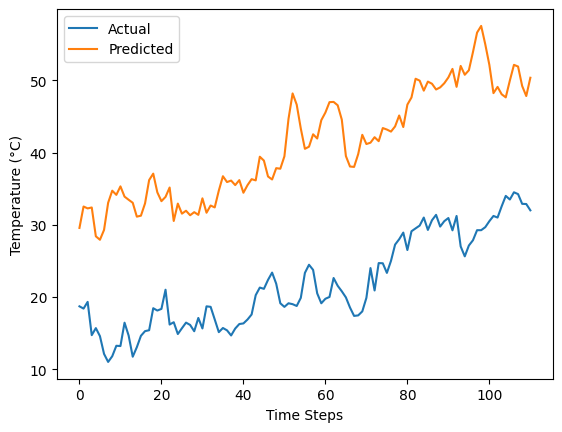

In [156]:
# Step 9: Evaluate the Model
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred.numpy())
        actuals.append(y_batch.numpy())

# Concatenate the predictions and actuals
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Inverse scaling to get back to the original scale
predictions = scaler_y.inverse_transform(predictions)
actuals = scaler_y.inverse_transform(actuals)

# Display the results
print("Predictions:", predictions[:10])  # Displaying the first 10 predictions
print("Actuals:", actuals[:10])  # Displaying the first 10 actual values

# Step 10: Plotting the predictions vs actual values
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()